Load necessary libraries.

In [29]:
### Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

### ML packages
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering #Hierarchial Clustering
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import defaultdict
import umap
from sklearn.metrics import silhouette_samples

### Msc
import warnings
from PIL import Image

### OOP
from ml_utils import SilhouetteEvaluator, ClusterEvaluator, make_gmm, make_hierarchical, make_spectral

Load dataset.

In [30]:
df = pd.read_csv('00_authors.csv').rename(columns={'Unnamed: 0': 'Author'}).drop(columns='BookID')
authors = df['Author'].values  # n_samples-length array

X_clean = df.drop(columns=['Author'])
X = X_clean.to_numpy()

# UMAP dimensionality reduction
warnings.filterwarnings("ignore", category=UserWarning, module="umap")  # suppress joblib warning
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X)

# Validation

The method with the highest silhouette score generalizes best!

## Kmeans++

Kmeans++ with and without UMAP:

### Generalizibility

Kmeans++ without dimension reduction:
The scores across K = {2: 0.2632255060236338, 3: 0.20849932363785784, 4: 0.1904947560045998, 5: 0.1924461042273646, 6: 0.16737576605101756, 7: 0.1565805704088574, 8: 0.16242539868041714, 9: 0.15016004946093003, 10: 0.13166013818539393}
Best K: 2
Kmeans++ with dimension reduction (UMAP):
The scores across K = {2: 0.59943473, 3: 0.68435156, 4: 0.6975769, 5: 0.60805935, 6: 0.557766, 7: 0.56372017, 8: 0.50572866, 9: 0.5044795, 10: 0.4624724}
Best K: 4


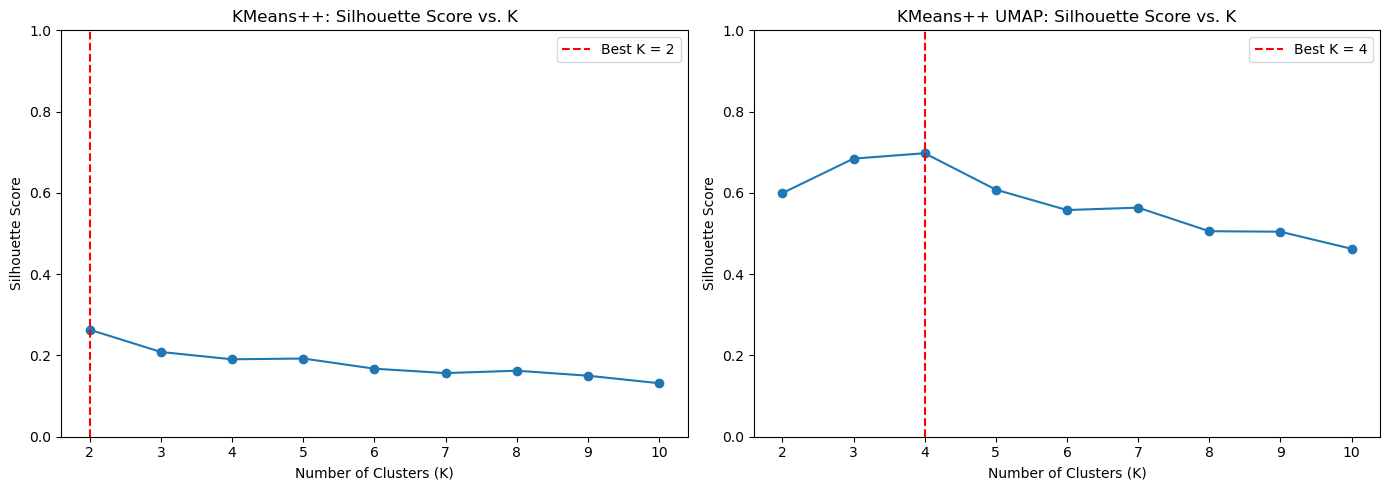

In [31]:
# Kmeans++ 
print('\033[1m' + 'Kmeans++ without dimension reduction:' + '\033[0m')
evaluator_kmeans = SilhouetteEvaluator(X, KMeans, k_range=range(2, 11), init='k-means++', n_init=10, max_iter=300)
scores, best_k = evaluator_kmeans.evaluate()
print(f'The scores across K = {scores}')
print(f"Best K: {best_k}")

# Kmeans++ with UMAP
print('\033[1m' + 'Kmeans++ with dimension reduction (UMAP):' + '\033[0m')
evaluator_kmeans_umap = SilhouetteEvaluator(X_umap, KMeans, k_range=range(2, 11), init='k-means++', n_init=10, max_iter=300)
scores, best_k = evaluator_kmeans_umap.evaluate()
print(f'The scores across K = {scores}')
print(f"Best K: {best_k}")

y_min = 0
y_max = 1

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

evaluator_kmeans.plot("KMeans++", ax=axs[0])
axs[0].set_ylim(y_min, y_max)

evaluator_kmeans_umap.plot("KMeans++ UMAP", ax=axs[1])
axs[1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('Media/05_kmeans_silhouette_score')
plt.show()


### Stability

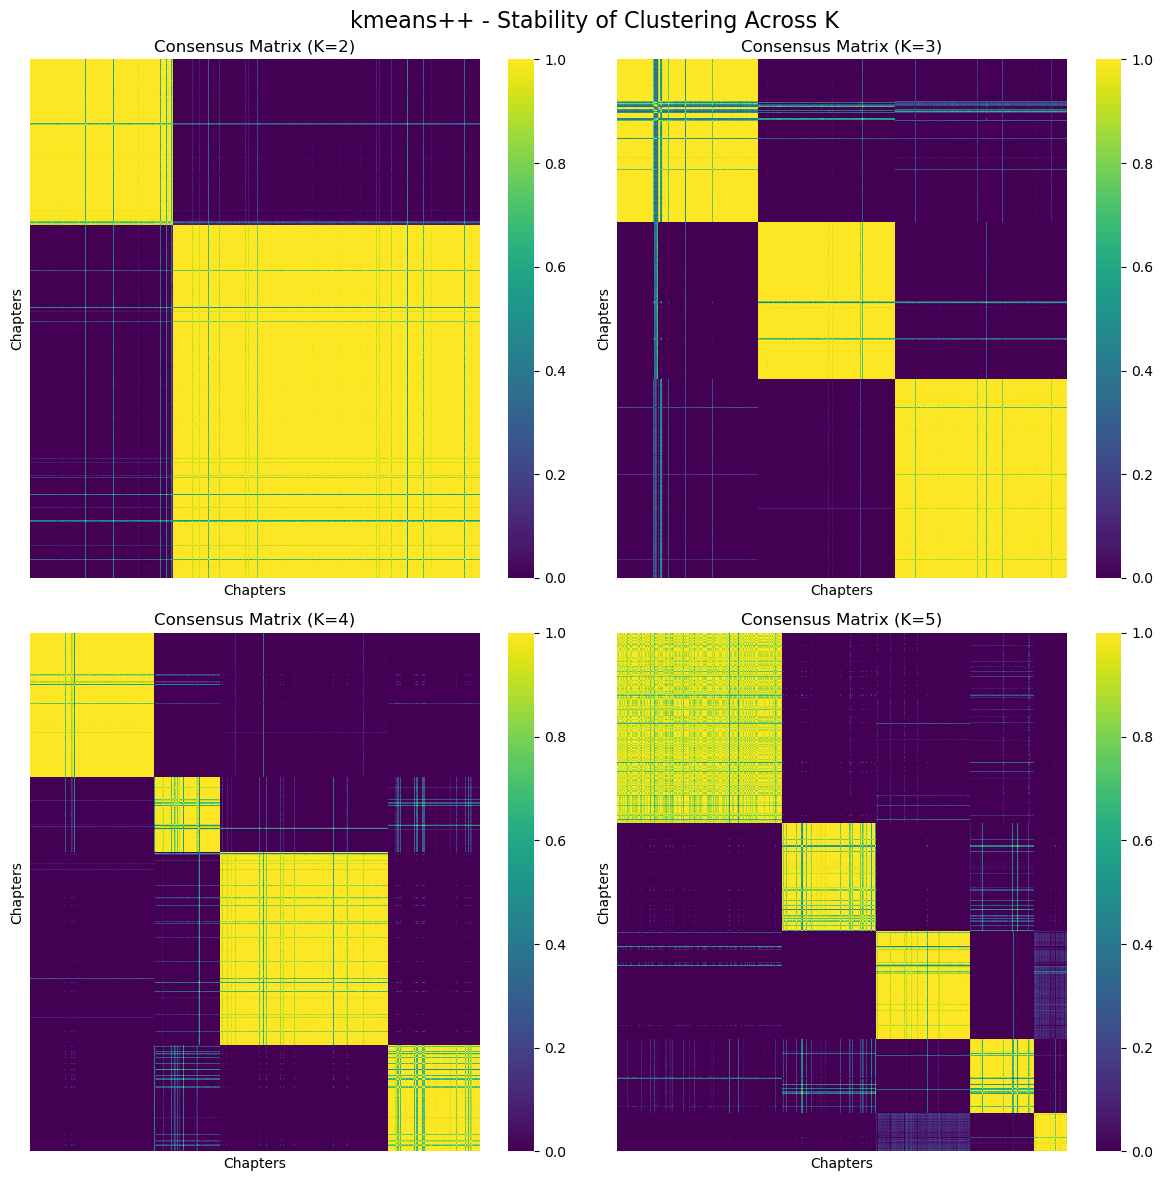

In [32]:
method = 'kmeans++'

rng = np.random.default_rng(42)
iterations = 100
K_values = [2, 3, 4, 5]
n_samples = X.shape[0]
sample_names = X_clean.index.to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, K in enumerate(K_values):
    consensus_matrix = np.zeros((n_samples, n_samples))
    sampled_matrix = np.zeros((n_samples, n_samples))

    for n in range(iterations):
        train_idx = rng.choice(n_samples, size=int(0.7 * n_samples), replace=False)
        X_train = X[train_idx]  # Using saved NumPy array

        km = KMeans(n_clusters=K, random_state=n, n_init=10)
        cluster_labels = km.fit_predict(X_train)

        sampled_matrix[np.ix_(train_idx, train_idx)] += 1
        co_members = np.equal.outer(cluster_labels, cluster_labels)
        consensus_matrix[np.ix_(train_idx, train_idx)] += co_members

    consensus_matrix = np.divide(consensus_matrix, sampled_matrix, where=(sampled_matrix != 0))
    consensus_matrix = np.nan_to_num(consensus_matrix)

    final_labels = KMeans(n_clusters=K, random_state=42, n_init=10).fit_predict(X)
    order_idx = np.argsort(final_labels)
    consensus_matrix = consensus_matrix[order_idx][:, order_idx]

    sns.heatmap(consensus_matrix, ax=axes[idx], cmap='viridis',
                xticklabels=sample_names[order_idx], yticklabels=sample_names[order_idx])
    axes[idx].set_title(f'Consensus Matrix (K={K})')
    axes[idx].tick_params(axis='x', rotation=90, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_xlabel('Chapters')
    axes[idx].set_ylabel('Chapters')

fig.suptitle(f'{method} - Stability of Clustering Across K', fontsize=16)
plt.tight_layout()
plt.savefig('Media/05_consensus_heatmaps_kmeans')
plt.show()

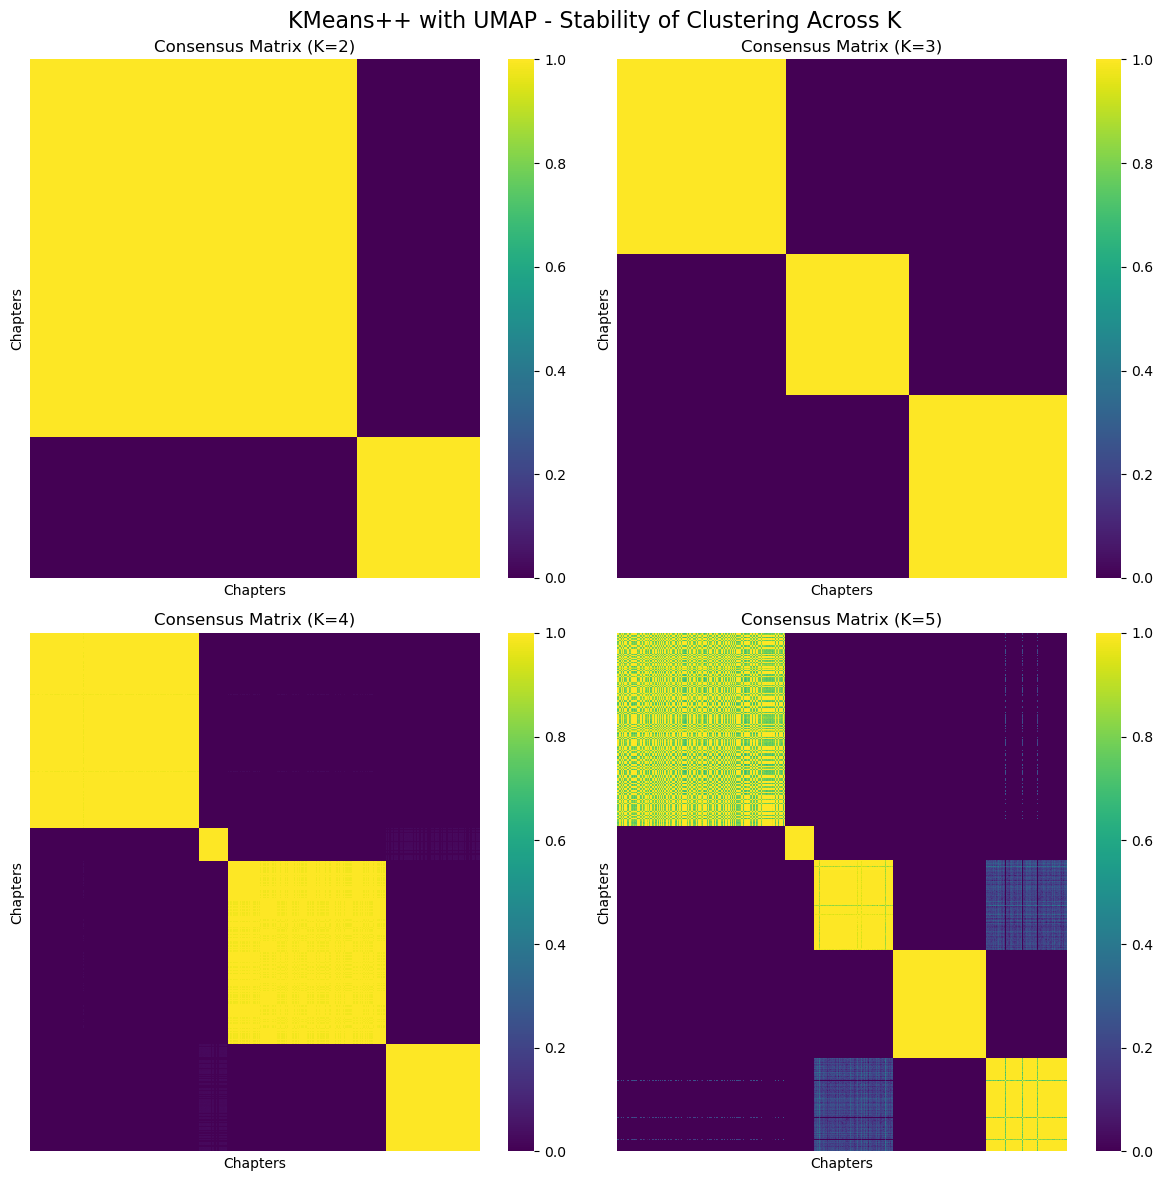

In [33]:
method = 'KMeans++ with UMAP'
rng = np.random.default_rng(42)
iterations = 100
K_values = [2, 3, 4, 5]
n_samples = X_umap.shape[0]
sample_names = X_clean.index.to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, K in enumerate(K_values):
    consensus_matrix = np.zeros((n_samples, n_samples))
    sampled_matrix = np.zeros((n_samples, n_samples))

    for i in range(iterations):
        idx_sample = rng.choice(n_samples, size=int(0.7 * n_samples), replace=False)
        X_sample = X_umap[idx_sample]

        km = KMeans(n_clusters=K, n_init=10, init='k-means++', random_state=i)
        labels = km.fit_predict(X_sample)

        sampled_matrix[np.ix_(idx_sample, idx_sample)] += 1
        co_members = np.equal.outer(labels, labels)
        consensus_matrix[np.ix_(idx_sample, idx_sample)] += co_members

    consensus_matrix = np.divide(consensus_matrix, sampled_matrix, where=sampled_matrix != 0)
    consensus_matrix = np.nan_to_num(consensus_matrix)

    final_labels = KMeans(n_clusters=K, n_init=10, init='k-means++', random_state=42).fit_predict(X_umap)
    order = np.argsort(final_labels)
    matrix_sorted = consensus_matrix[order][:, order]

    sns.heatmap(matrix_sorted, ax=axes[idx], cmap='viridis',
                xticklabels=sample_names[order], yticklabels=sample_names[order])
    axes[idx].set_title(f'Consensus Matrix (K={K})')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_xlabel('Chapters')
    axes[idx].set_ylabel('Chapters')

fig.suptitle(f'{method} - Stability of Clustering Across K', fontsize=16)
plt.tight_layout()
plt.savefig('Media/05_consensus_heatmaps_kmeans_umap')
plt.show()

## Gaussian Mixture Models

### Generalizibility

GMM without dimension reduction:
The scores across K = {2: 0.24476088625636777, 3: 0.20648025338069953, 4: 0.14927671031794415, 5: 0.17996193297648969, 6: 0.11822271757848497, 7: 0.12336260868846687, 8: 0.14816074016627137, 9: 0.1283175005255786, 10: 0.11341245864617346}
Best K: 2
GMM with dimension reduction (UMAP):
The scores across K = {2: 0.59943473, 3: 0.68435156, 4: 0.6975769, 5: 0.60627675, 6: 0.55574113, 7: 0.5156185, 8: 0.56067187, 9: 0.51924455, 10: 0.46065006}
Best K: 4


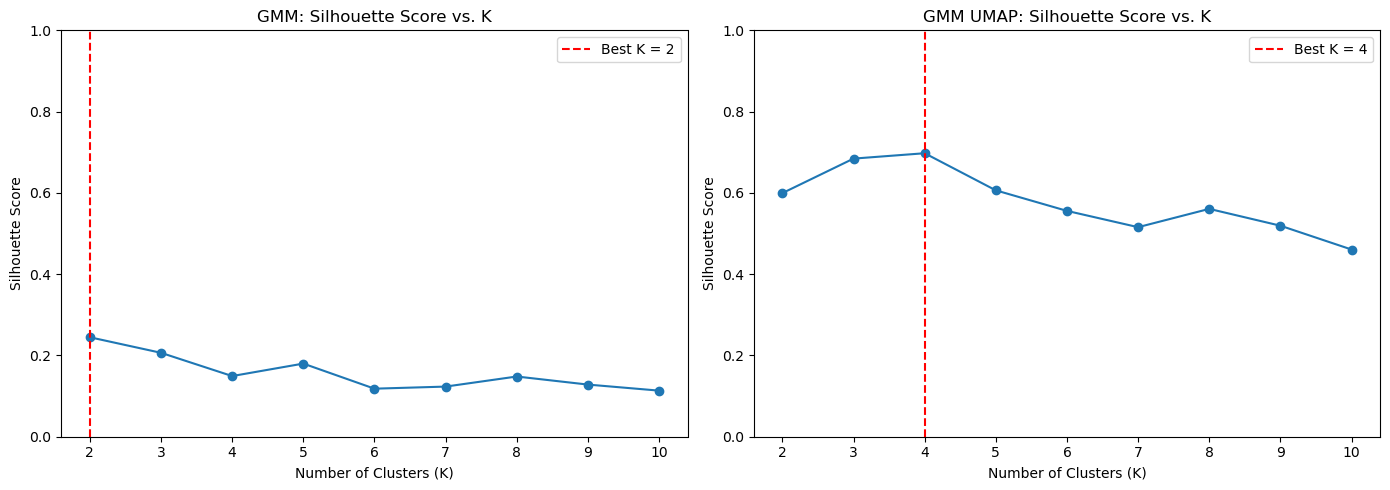

In [34]:
# GMM
print('\033[1m' + 'GMM without dimension reduction:' + '\033[0m')
evaluator_gmm = SilhouetteEvaluator(X, make_gmm(), k_range=range(2, 11))
scores, best_k = evaluator_gmm.evaluate()
print(f'The scores across K = {scores}')
print(f"Best K: {best_k}")

# GMM with UMAP
print('\033[1m' + 'GMM with dimension reduction (UMAP):' + '\033[0m')
evaluator_gmm_umap = SilhouetteEvaluator(X_umap, make_gmm(), k_range=range(2, 11))
scores, best_k = evaluator_gmm_umap.evaluate()
print(f'The scores across K = {scores}')
print(f"Best K: {best_k}")

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

evaluator_gmm.plot("GMM", ax=axs[0])
axs[0].set_ylim(y_min, y_max)

evaluator_gmm_umap.plot("GMM UMAP", ax=axs[1])
axs[1].set_ylim(y_min, y_max)

plt.tight_layout()

plt.savefig('Media/05_gmm_silhouette_score')
plt.show()

### Stability

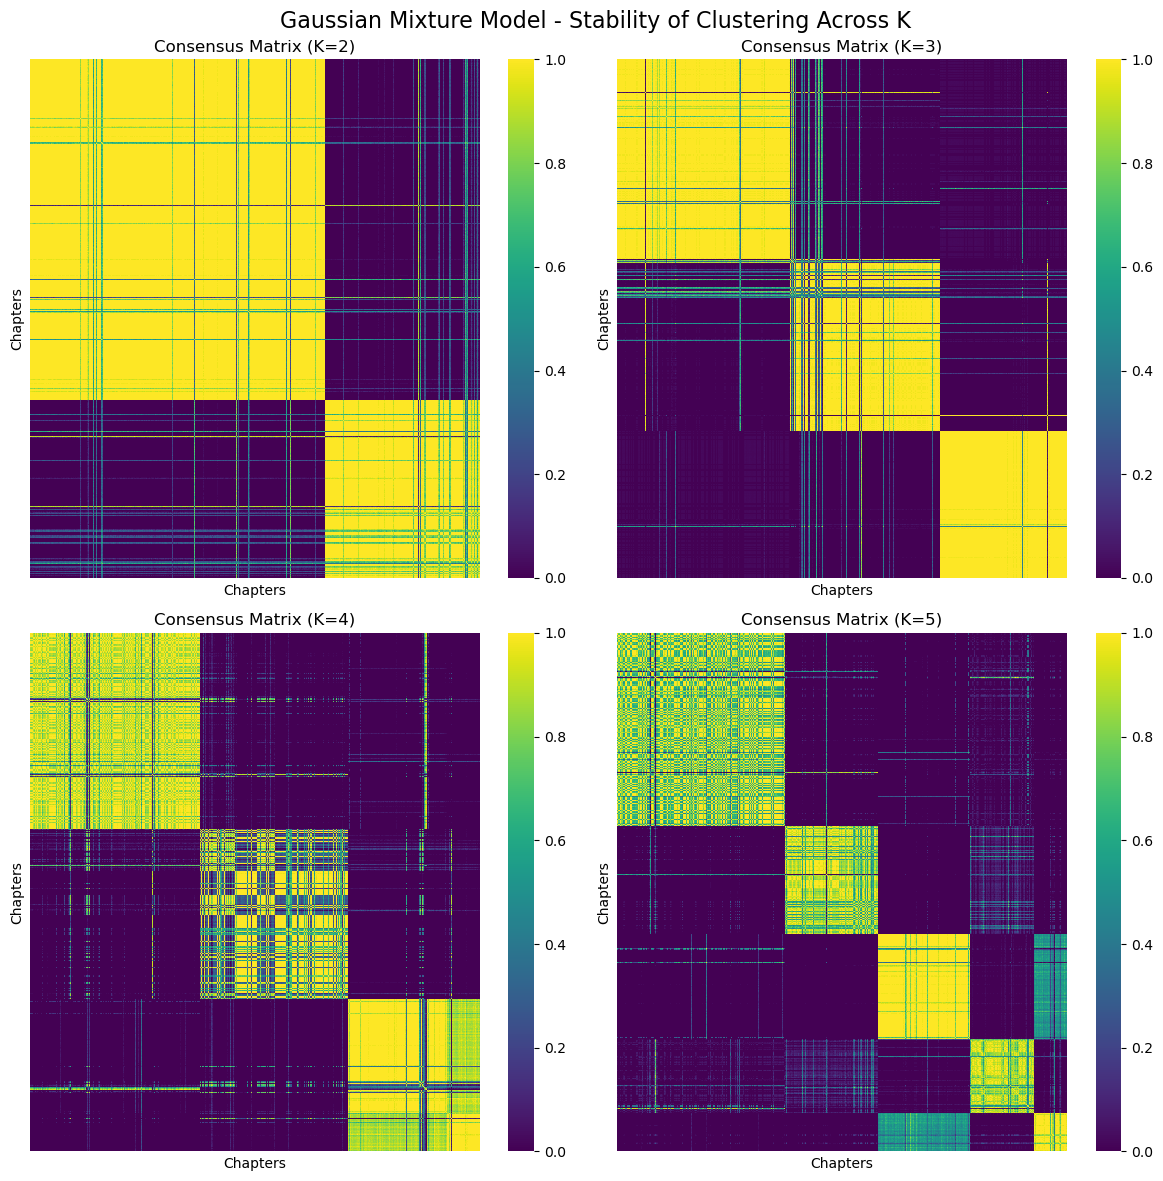

In [35]:
method = 'Gaussian Mixture Model'
rng = np.random.default_rng(42)
iterations = 100
K_values = [2, 3, 4, 5]
n_samples = X.shape[0]
sample_names = X_clean.index.to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, K in enumerate(K_values):
    consensus = np.zeros((n_samples, n_samples))
    sampled = np.zeros((n_samples, n_samples))

    for i in range(iterations):
        idx_sample = rng.choice(n_samples, size=int(0.7 * n_samples), replace=False)
        X_sample = X[idx_sample]  # NumPy version for GMM

        gmm = GaussianMixture(n_components=K, random_state=i)
        labels = gmm.fit(X_sample).predict(X_sample)

        sampled[np.ix_(idx_sample, idx_sample)] += 1
        co_members = np.equal.outer(labels, labels)
        consensus[np.ix_(idx_sample, idx_sample)] += co_members

    consensus = np.divide(consensus, sampled, where=sampled != 0)
    consensus = np.nan_to_num(consensus)

    final_labels = GaussianMixture(n_components=K, random_state=42).fit(X).predict(X)
    order = np.argsort(final_labels)
    matrix_sorted = consensus[order][:, order]

    sns.heatmap(matrix_sorted, ax=axes[idx], cmap='viridis',
                xticklabels=sample_names[order], yticklabels=sample_names[order])
    axes[idx].set_title(f'Consensus Matrix (K={K})')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_xlabel('Chapters')
    axes[idx].set_ylabel('Chapters')
    axes[idx].tick_params(axis='x', rotation=90, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)

fig.suptitle(f'{method} - Stability of Clustering Across K', fontsize=16)
plt.tight_layout()
plt.savefig('Media/05_consensus_heatmaps_gmm')
plt.show()

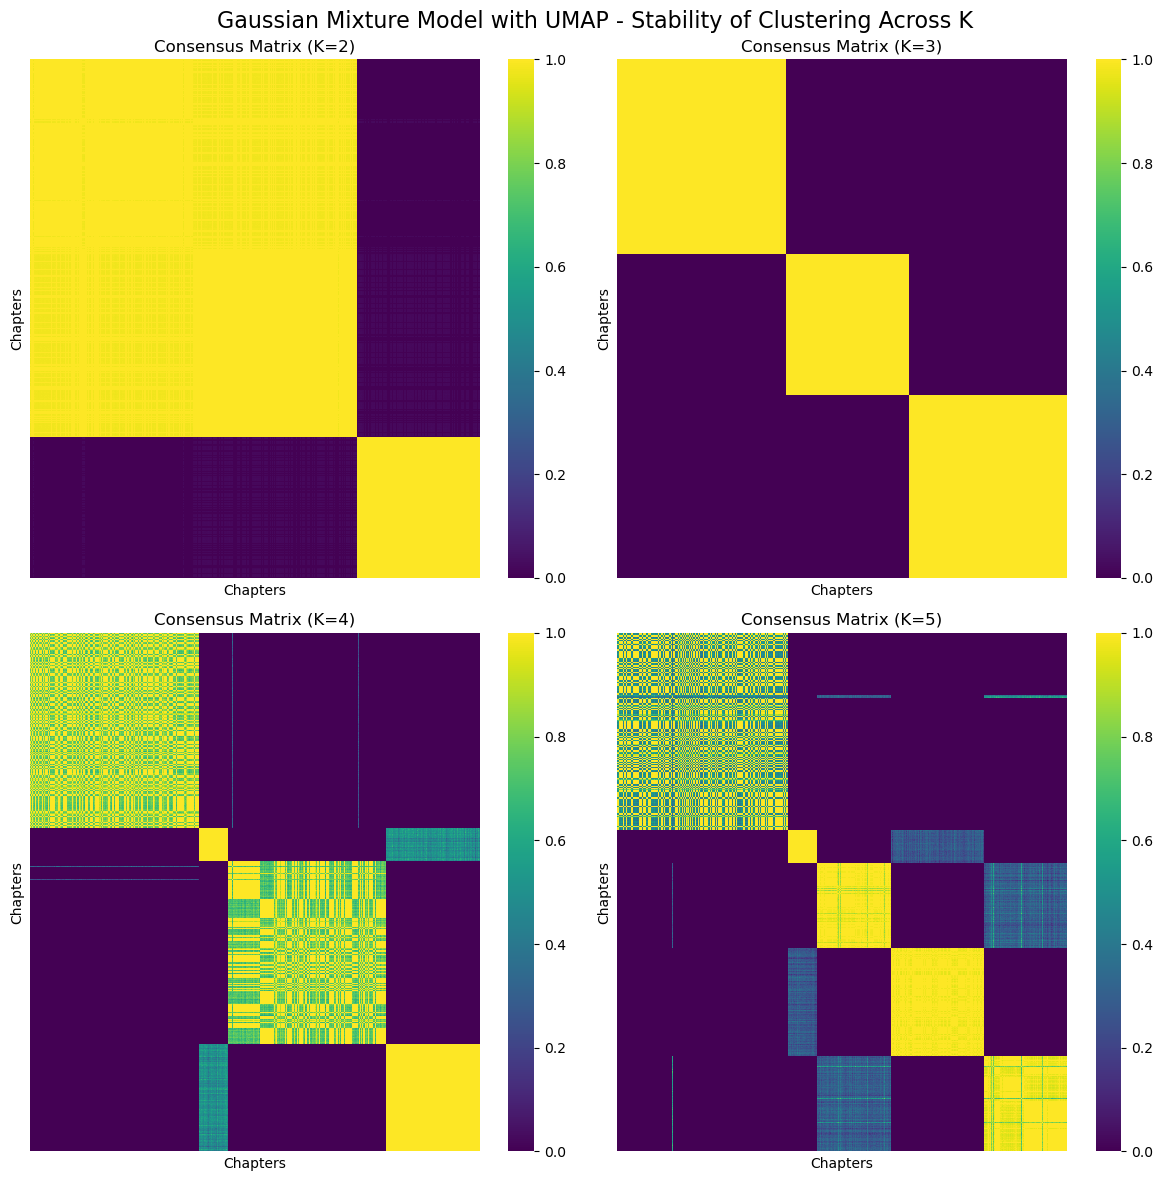

In [36]:
method = 'Gaussian Mixture Model with UMAP'
rng = np.random.default_rng(42)
iterations = 100
K_values = [2, 3, 4, 5]
n_samples = X_umap.shape[0]
sample_names = X_clean.index.to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, K in enumerate(K_values):
    consensus = np.zeros((n_samples, n_samples))
    sampled = np.zeros((n_samples, n_samples))

    for i in range(iterations):
        idx_sample = rng.choice(n_samples, size=int(0.7 * n_samples), replace=False)
        X_sample = X_umap[idx_sample]

        gmm = GaussianMixture(n_components=K, random_state=i)
        labels = gmm.fit(X_sample).predict(X_sample)

        sampled[np.ix_(idx_sample, idx_sample)] += 1
        co_members = np.equal.outer(labels, labels)
        consensus[np.ix_(idx_sample, idx_sample)] += co_members

    consensus = np.divide(consensus, sampled, where=sampled != 0)
    consensus = np.nan_to_num(consensus)

    final_labels = GaussianMixture(n_components=K, random_state=42).fit(X_umap).predict(X_umap)
    order = np.argsort(final_labels)
    matrix_sorted = consensus[order][:, order]

    sns.heatmap(matrix_sorted, ax=axes[idx], cmap='viridis',
                xticklabels=sample_names[order], yticklabels=sample_names[order])
    axes[idx].set_title(f'Consensus Matrix (K={K})')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_xlabel('Chapters')
    axes[idx].set_ylabel('Chapters')
    axes[idx].tick_params(axis='x', rotation=90, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)

fig.suptitle(f'{method} - Stability of Clustering Across K', fontsize=16)
plt.tight_layout()
plt.savefig('Media/05_consensus_heatmaps_gmm_umap')
plt.show()

## Spectral Clustering

### Generalizibility

Spectral Clustering:
The scores across K = {2: 0.1408300984760483, 3: 0.20696881798137212, 4: 0.2020762541851448, 5: 0.1914837165759898, 6: 0.16570630789830376, 7: 0.15006558354299535, 8: 0.15779098304820008, 9: 0.13754422703918343, 10: 0.13369165128481791}
Best K: 3


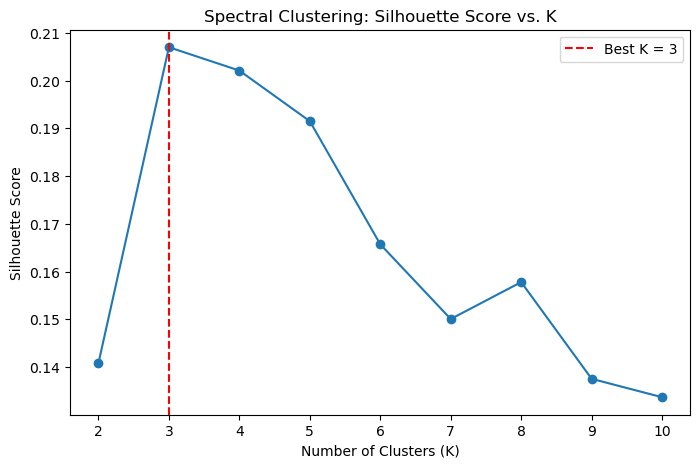

In [37]:
print('\033[1m' + 'Spectral Clustering:' + '\033[0m')
evaluator_spectral = SilhouetteEvaluator(X, make_spectral(affinity = 'nearest_neighbors'), k_range=range(2, 11))
scores, best_k = evaluator_spectral.evaluate()
print(f'The scores across K = {scores}')
print(f"Best K: {best_k}")

evaluator_spectral.plot('Spectral Clustering')
plt.savefig('Media/05_spectral_silhouette_score')

Although the silhouette score is commonly used to evaluate clustering performance, it assumes that clusters are spherical in shape, which does not align with the strengths of spectral clustering. Spectral clustering excels at uncovering non-linear and arbitrarily shaped cluster structures, which silhouette score is not well-equipped to quantify. Therefore, the low silhouette score observed here may understate the actual performance of spectral clustering. In fact, the spectral embedding reveals visually distinct and meaningful clusters (see notebook 02), suggesting that the method is effective despite the numerical metric.

### Stability

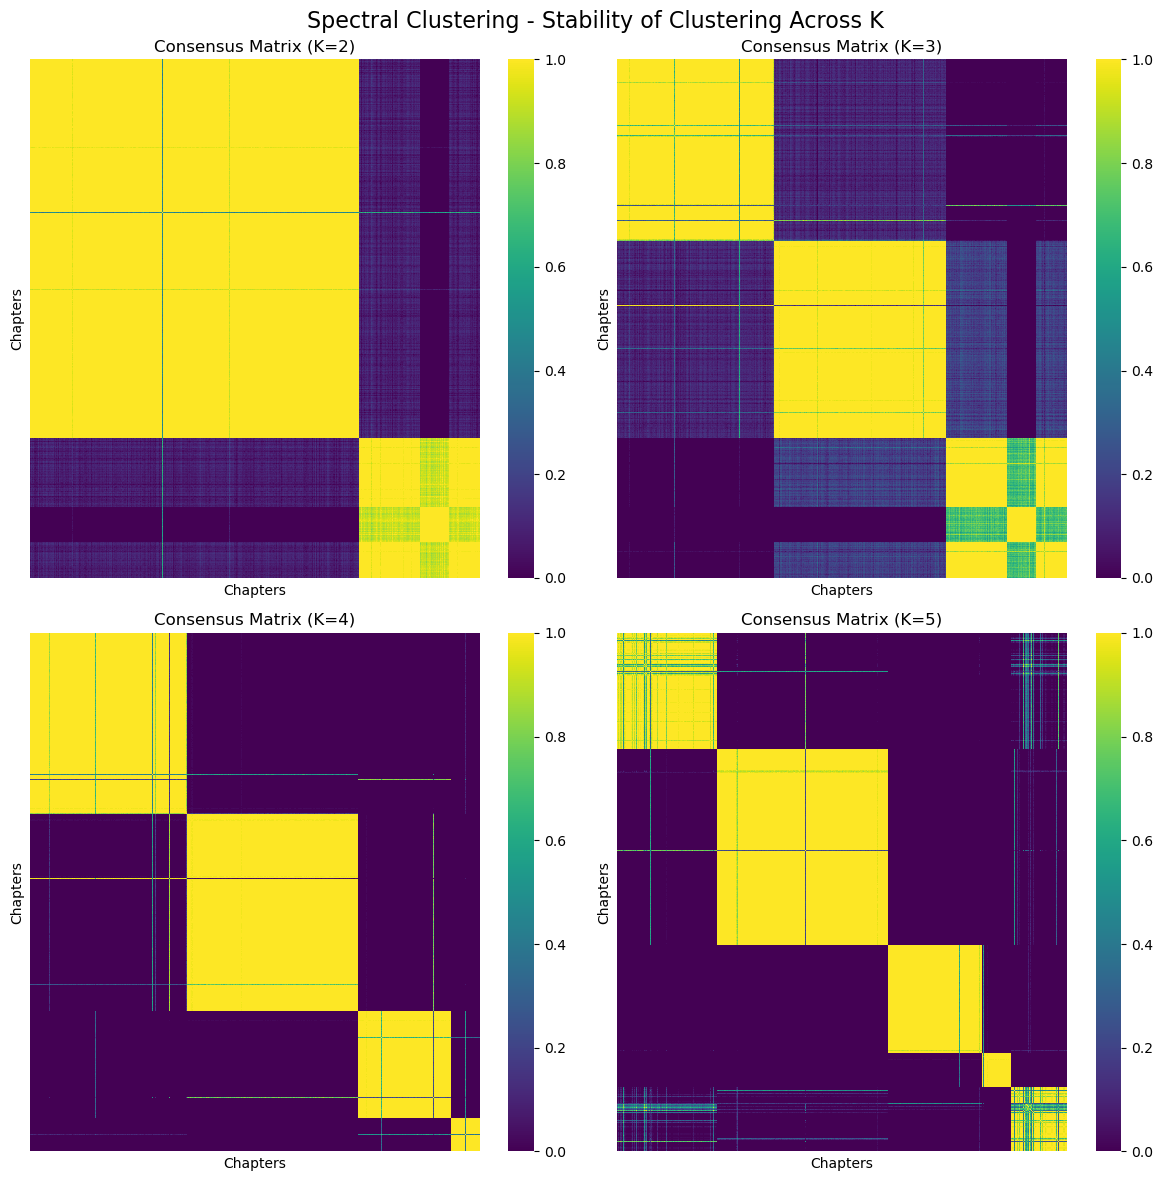

In [38]:
## METHOD
method = 'Spectral Clustering'

rng = np.random.default_rng(42)
iterations = 100
K_values = [2, 3, 4, 5]
n_samples = X_clean.shape[0]
sample_names = X_clean.index.to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, K in enumerate(K_values):
    consensus_matrix = np.zeros((n_samples, n_samples))
    sampled_matrix = np.zeros((n_samples, n_samples))

    for n in range(iterations):
        train_idx = rng.choice(n_samples, size=int(0.7 * n_samples), replace=False)
        X_train = X_clean.iloc[train_idx].to_numpy()

        sc = SpectralClustering(n_clusters=K, affinity='nearest_neighbors', assign_labels='kmeans', random_state=n)
        cluster_labels = sc.fit_predict(X_train)

        sampled_matrix[np.ix_(train_idx, train_idx)] += 1
        co_members = np.equal.outer(cluster_labels, cluster_labels)
        consensus_matrix[np.ix_(train_idx, train_idx)] += co_members

    consensus_matrix = np.divide(consensus_matrix, sampled_matrix, where=(sampled_matrix != 0))
    consensus_matrix = np.nan_to_num(consensus_matrix)

    final_labels = SpectralClustering(n_clusters=K, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42).fit_predict(X_clean)
    order_idx = np.argsort(final_labels)
    consensus_matrix = consensus_matrix[order_idx][:, order_idx]

    sns.heatmap(consensus_matrix, ax=axes[idx], cmap='viridis',
                xticklabels=sample_names[order_idx], yticklabels=sample_names[order_idx])
    axes[idx].set_title(f'Consensus Matrix (K={K})')
    axes[idx].tick_params(axis='x', rotation=90, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_xlabel('Chapters')
    axes[idx].set_ylabel('Chapters')

fig.suptitle(f'{method} - Stability of Clustering Across K', fontsize=16)

plt.tight_layout()
plt.savefig('Media/05_consensus_heatmaps_spectral')
plt.show()

$K=4$ is the clear winner!

## Hierarchial Clustering

Using the parameters 'ward' and 'euclidean' (because we have seen in notebook 04 that these have the highest accuracy)!

### Generalizibility

Hierarchical Clustering without dimension reduction:
The scores across K = {2: 0.23967574687100793, 3: 0.20437373269232859, 4: 0.18421197778513682, 5: 0.18654800991576861, 6: 0.16319550456880302, 7: 0.14995813568113975, 8: 0.1518500219855489, 9: 0.14745055233611987, 10: 0.1167264049290792}
Best K: 2
Hierarchical Clustering with dimension reduction (UMAP):
The scores across K = {2: 0.59943473, 3: 0.68435156, 4: 0.6975769, 5: 0.60349095, 6: 0.5471597, 7: 0.5380937, 8: 0.53579855, 9: 0.47313103, 10: 0.42873582}
Best K: 4


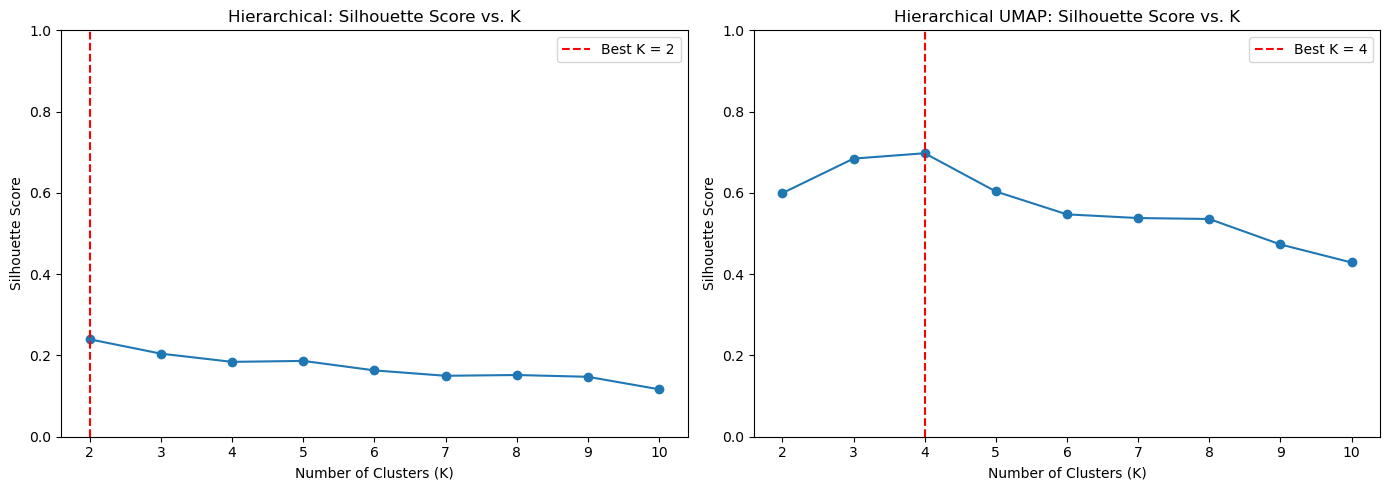

In [39]:
# Hierarchical Clustering
print('\033[1m' + 'Hierarchical Clustering without dimension reduction:' + '\033[0m')
evaluator_hier = SilhouetteEvaluator(X, make_hierarchical(linkage='ward', metric='euclidean'), k_range=range(2, 11))
scores, best_k = evaluator_hier.evaluate()
print(f'The scores across K = {scores}')
print(f"Best K: {best_k}")

# Hierarchical Clustering with UMAP
print('\033[1m' + 'Hierarchical Clustering with dimension reduction (UMAP):' + '\033[0m')
evaluator_hier_umap = SilhouetteEvaluator(X_umap, make_hierarchical(linkage='ward', metric='euclidean'), k_range=range(2, 11))
scores, best_k = evaluator_hier_umap.evaluate()
print(f'The scores across K = {scores}')
print(f"Best K: {best_k}")

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

evaluator_hier.plot("Hierarchical", ax=axs[0])
axs[0].set_ylim(y_min, y_max)

evaluator_hier_umap.plot("Hierarchical UMAP", ax=axs[1])
axs[1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('Media/05_silhouette_score_across_methods.png')
plt.show()

### Stability

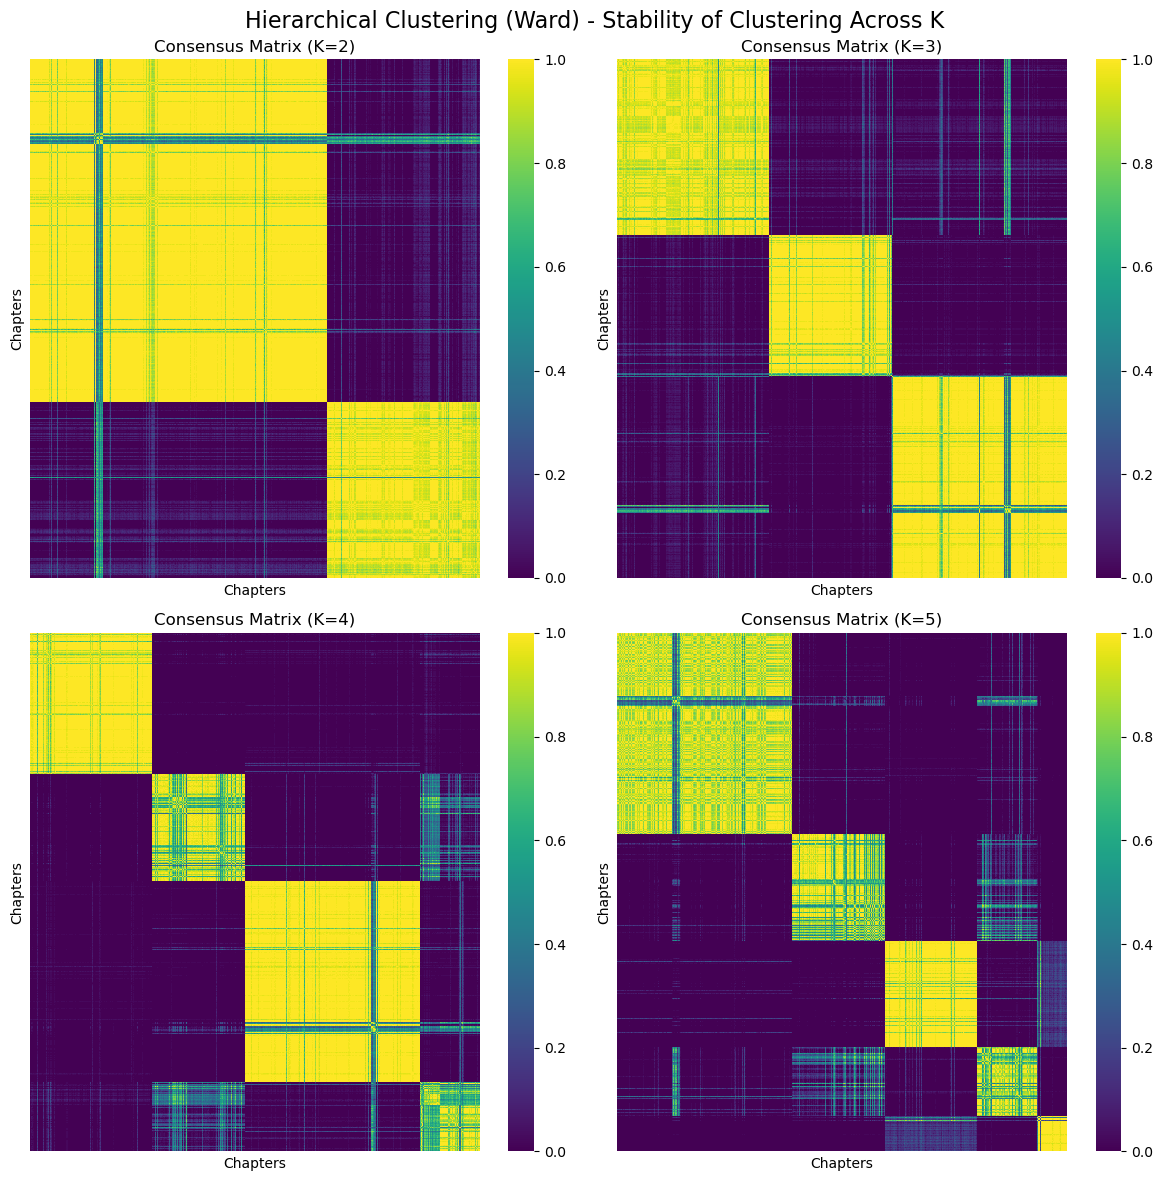

In [40]:
method = 'Hierarchical Clustering (Ward)'
rng = np.random.default_rng(42)
iterations = 100
K_values = [2, 3, 4, 5]
n_samples = X.shape[0]
sample_names = X_clean.index.to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, K in enumerate(K_values):
    consensus = np.zeros((n_samples, n_samples))
    sampled = np.zeros((n_samples, n_samples))

    for i in range(iterations):
        idx_sample = rng.choice(n_samples, size=int(0.7 * n_samples), replace=False)
        X_sample = X[idx_sample]

        model = AgglomerativeClustering(n_clusters=K, linkage='ward')
        labels = model.fit_predict(X_sample)

        sampled[np.ix_(idx_sample, idx_sample)] += 1
        co_members = np.equal.outer(labels, labels)
        consensus[np.ix_(idx_sample, idx_sample)] += co_members

    consensus = np.divide(consensus, sampled, where=sampled != 0)
    consensus = np.nan_to_num(consensus)

    final_labels = AgglomerativeClustering(n_clusters=K, linkage='ward').fit_predict(X)
    order = np.argsort(final_labels)
    matrix_sorted = consensus[order][:, order]

    sns.heatmap(matrix_sorted, ax=axes[idx], cmap='viridis',
                xticklabels=sample_names[order], yticklabels=sample_names[order])
    axes[idx].set_title(f'Consensus Matrix (K={K})')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_xlabel('Chapters')
    axes[idx].set_ylabel('Chapters')
    axes[idx].tick_params(axis='x', rotation=90, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)

fig.suptitle(f'{method} - Stability of Clustering Across K', fontsize=16)
plt.tight_layout()
plt.savefig('Media/05_consensus_heatmaps_hierarchical')
plt.show()

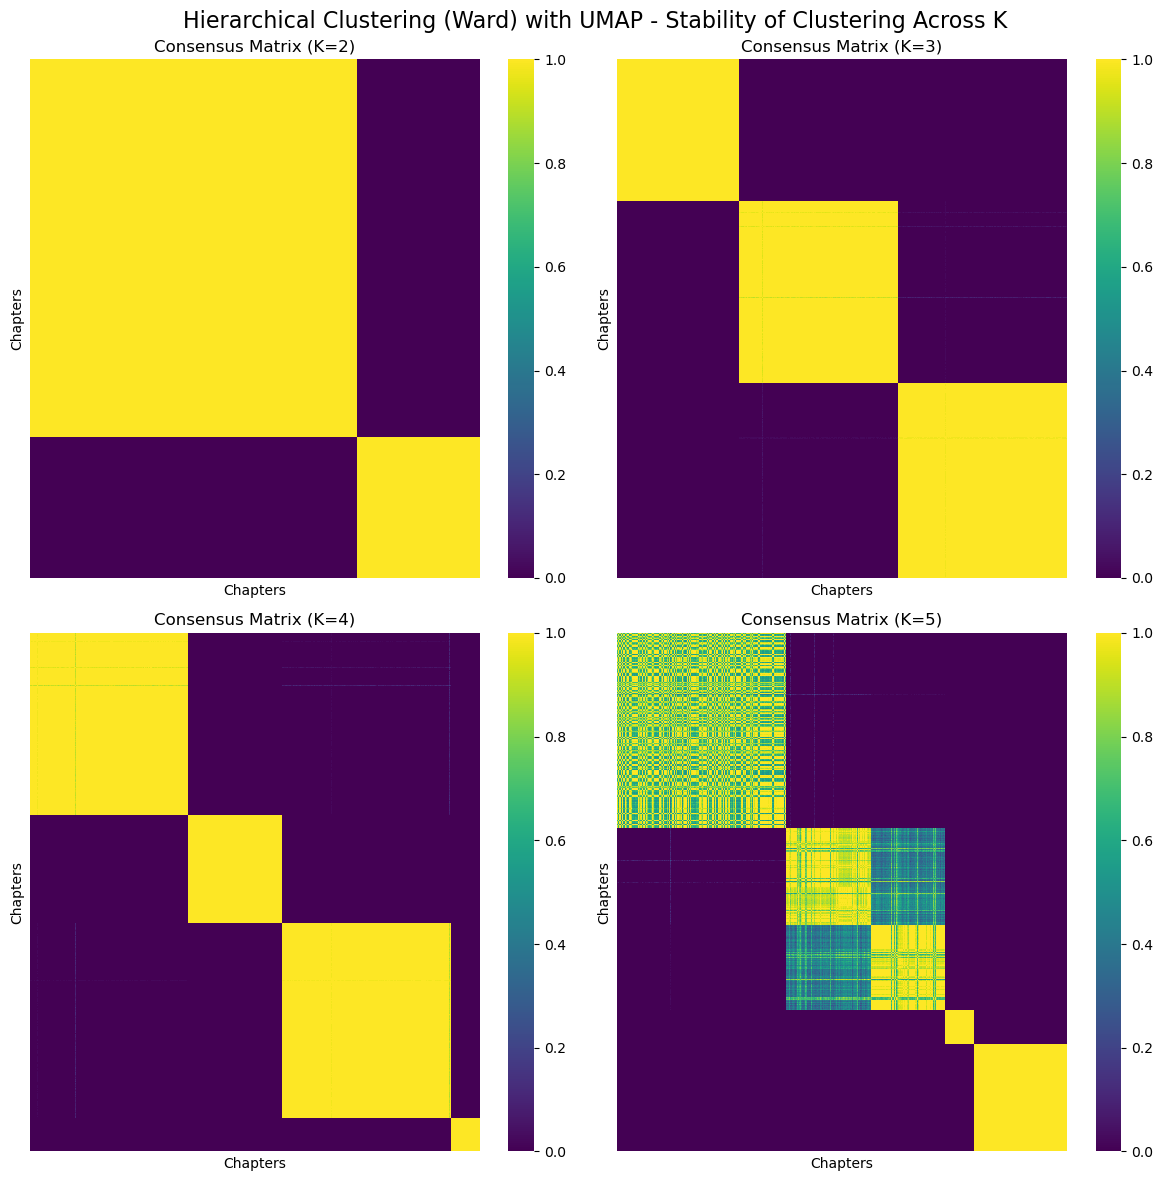

In [41]:
method = 'Hierarchical Clustering (Ward) with UMAP'
rng = np.random.default_rng(42)
iterations = 100
K_values = [2, 3, 4, 5]
n_samples = X_umap.shape[0]
sample_names = X_clean.index.to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, K in enumerate(K_values):
    consensus = np.zeros((n_samples, n_samples))
    sampled = np.zeros((n_samples, n_samples))

    for i in range(iterations):
        idx_sample = rng.choice(n_samples, size=int(0.7 * n_samples), replace=False)
        X_sample = X_umap[idx_sample]

        model = AgglomerativeClustering(n_clusters=K, linkage='ward')
        labels = model.fit_predict(X_sample)

        sampled[np.ix_(idx_sample, idx_sample)] += 1
        co_members = np.equal.outer(labels, labels)
        consensus[np.ix_(idx_sample, idx_sample)] += co_members

    consensus = np.divide(consensus, sampled, where=sampled != 0)
    consensus = np.nan_to_num(consensus)

    final_labels = AgglomerativeClustering(n_clusters=K, linkage='ward').fit_predict(X_umap)
    order = np.argsort(final_labels)
    matrix_sorted = consensus[order][:, order]

    sns.heatmap(matrix_sorted, ax=axes[idx], cmap='viridis',
                xticklabels=sample_names[order], yticklabels=sample_names[order])
    axes[idx].set_title(f'Consensus Matrix (K={K})')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].set_xlabel('Chapters')
    axes[idx].set_ylabel('Chapters')
    axes[idx].tick_params(axis='x', rotation=90, labelsize=8)
    axes[idx].tick_params(axis='y', labelsize=8)

fig.suptitle(f'{method} - Stability of Clustering Across K', fontsize=16)
plt.tight_layout()
plt.savefig('Media/05_consensus_heatmaps_hierarchical_umap')
plt.show()

# Comparison Viz

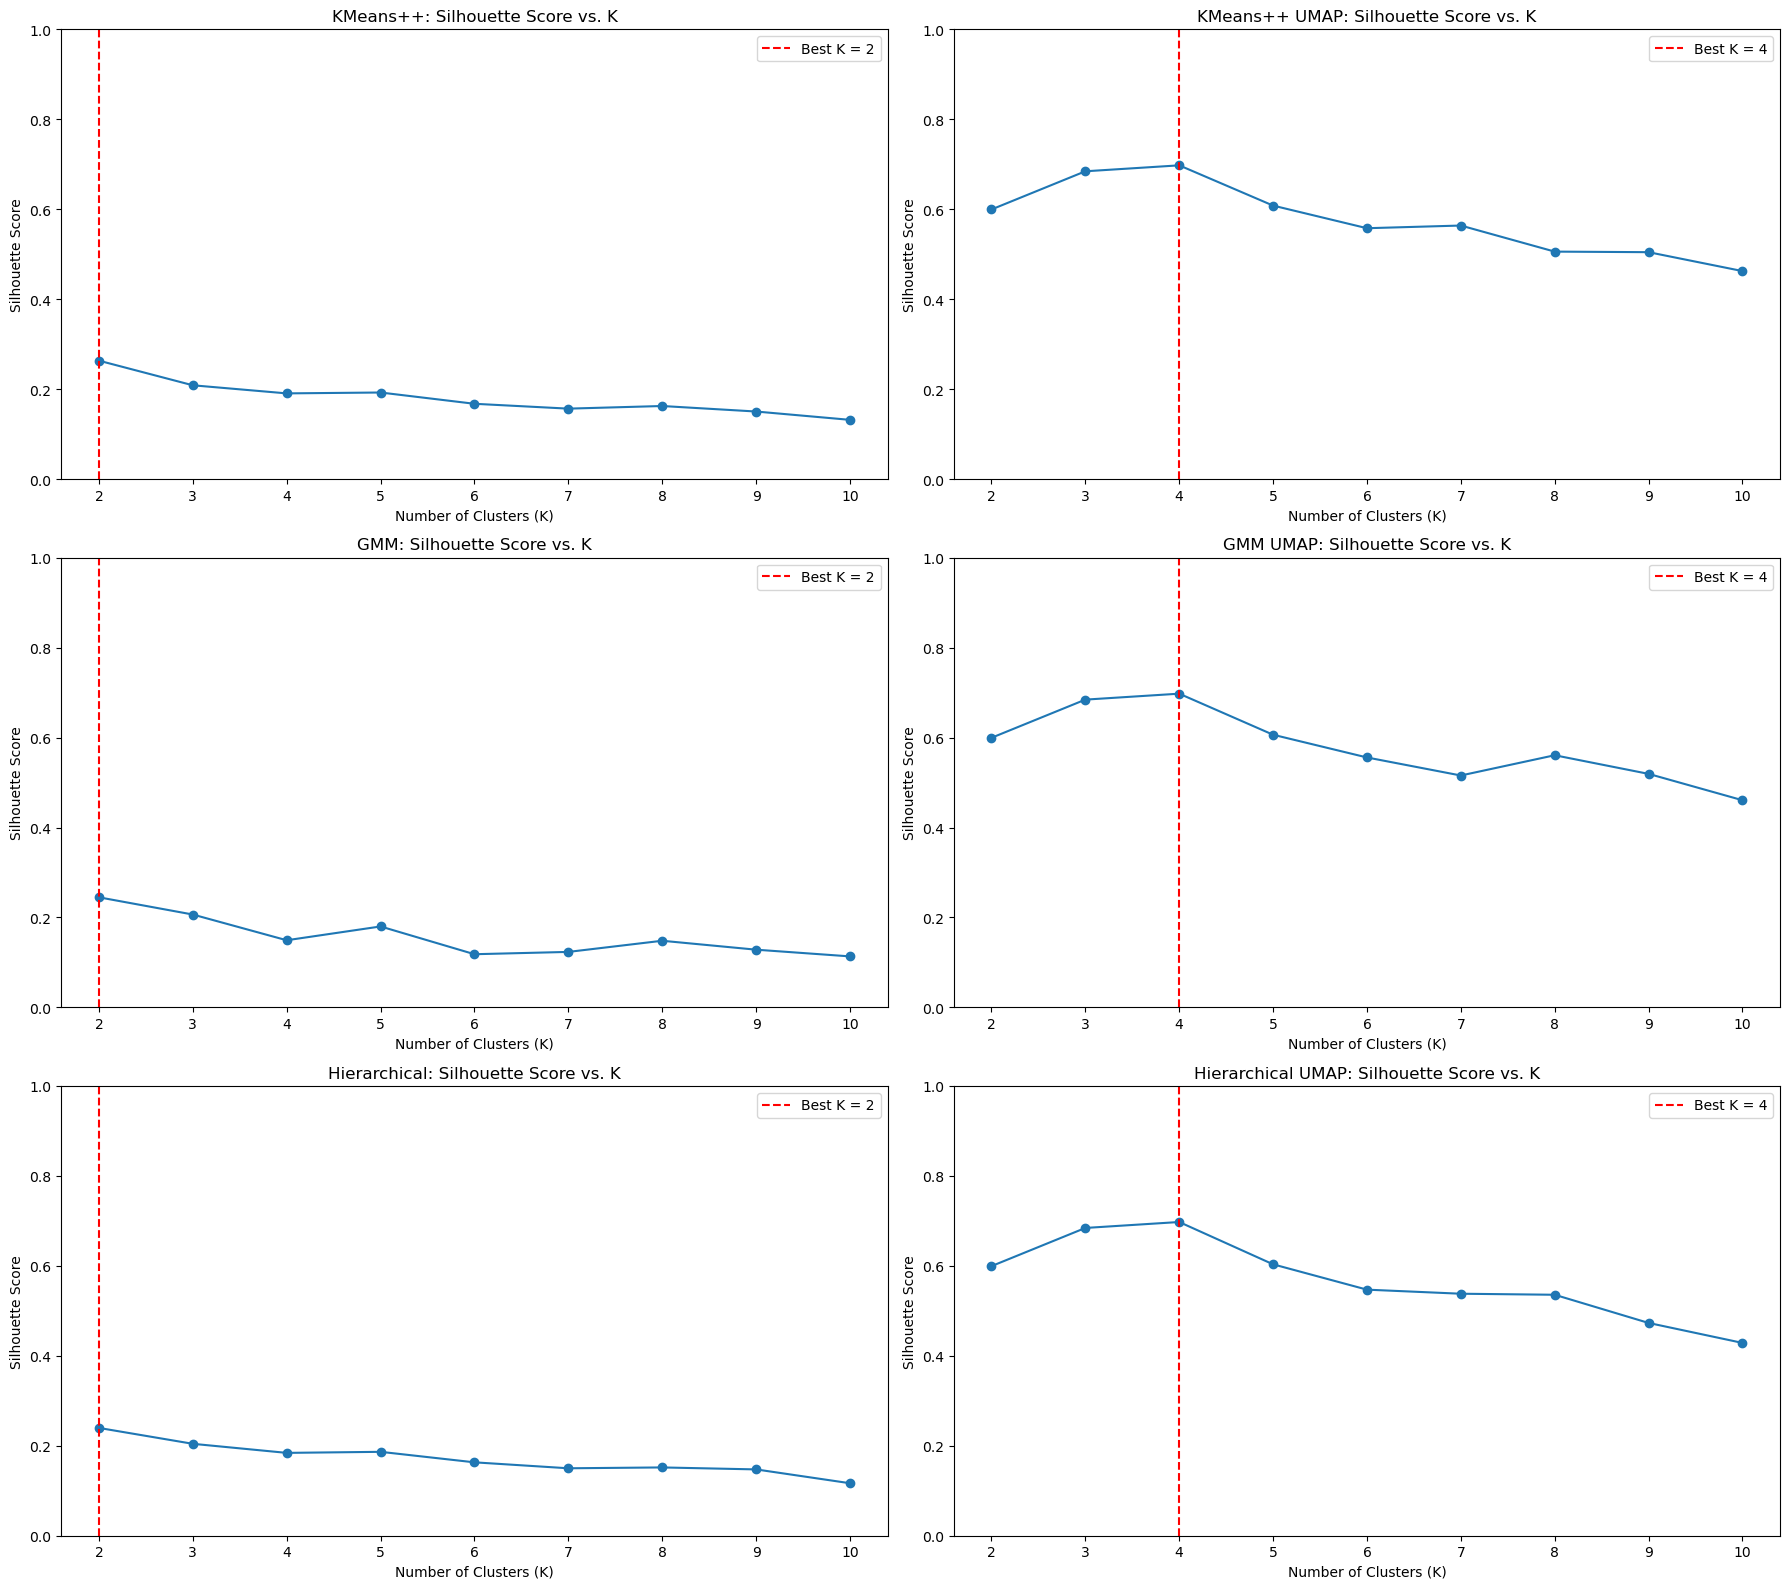

In [42]:
fig, axs = plt.subplots(3, 2, figsize=(18, 16))

evaluator_kmeans.plot("KMeans++", ax=axs[0,0])
axs[0,0].set_ylim(y_min, y_max)
evaluator_kmeans_umap.plot("KMeans++ UMAP", ax=axs[0,1])
axs[0,1].set_ylim(y_min, y_max)

evaluator_gmm.plot("GMM", ax=axs[1,0])
axs[1,0].set_ylim(y_min, y_max)

evaluator_gmm_umap.plot("GMM UMAP", ax=axs[1,1])
axs[1,1].set_ylim(y_min, y_max)

evaluator_hier.plot("Hierarchical", ax=axs[2,0])
axs[2,0].set_ylim(y_min, y_max)

evaluator_hier_umap.plot("Hierarchical UMAP", ax=axs[2,1])
axs[2,1].set_ylim(y_min, y_max)

plt.savefig('Media/05_silhouette_score_across_methods')
plt.tight_layout()

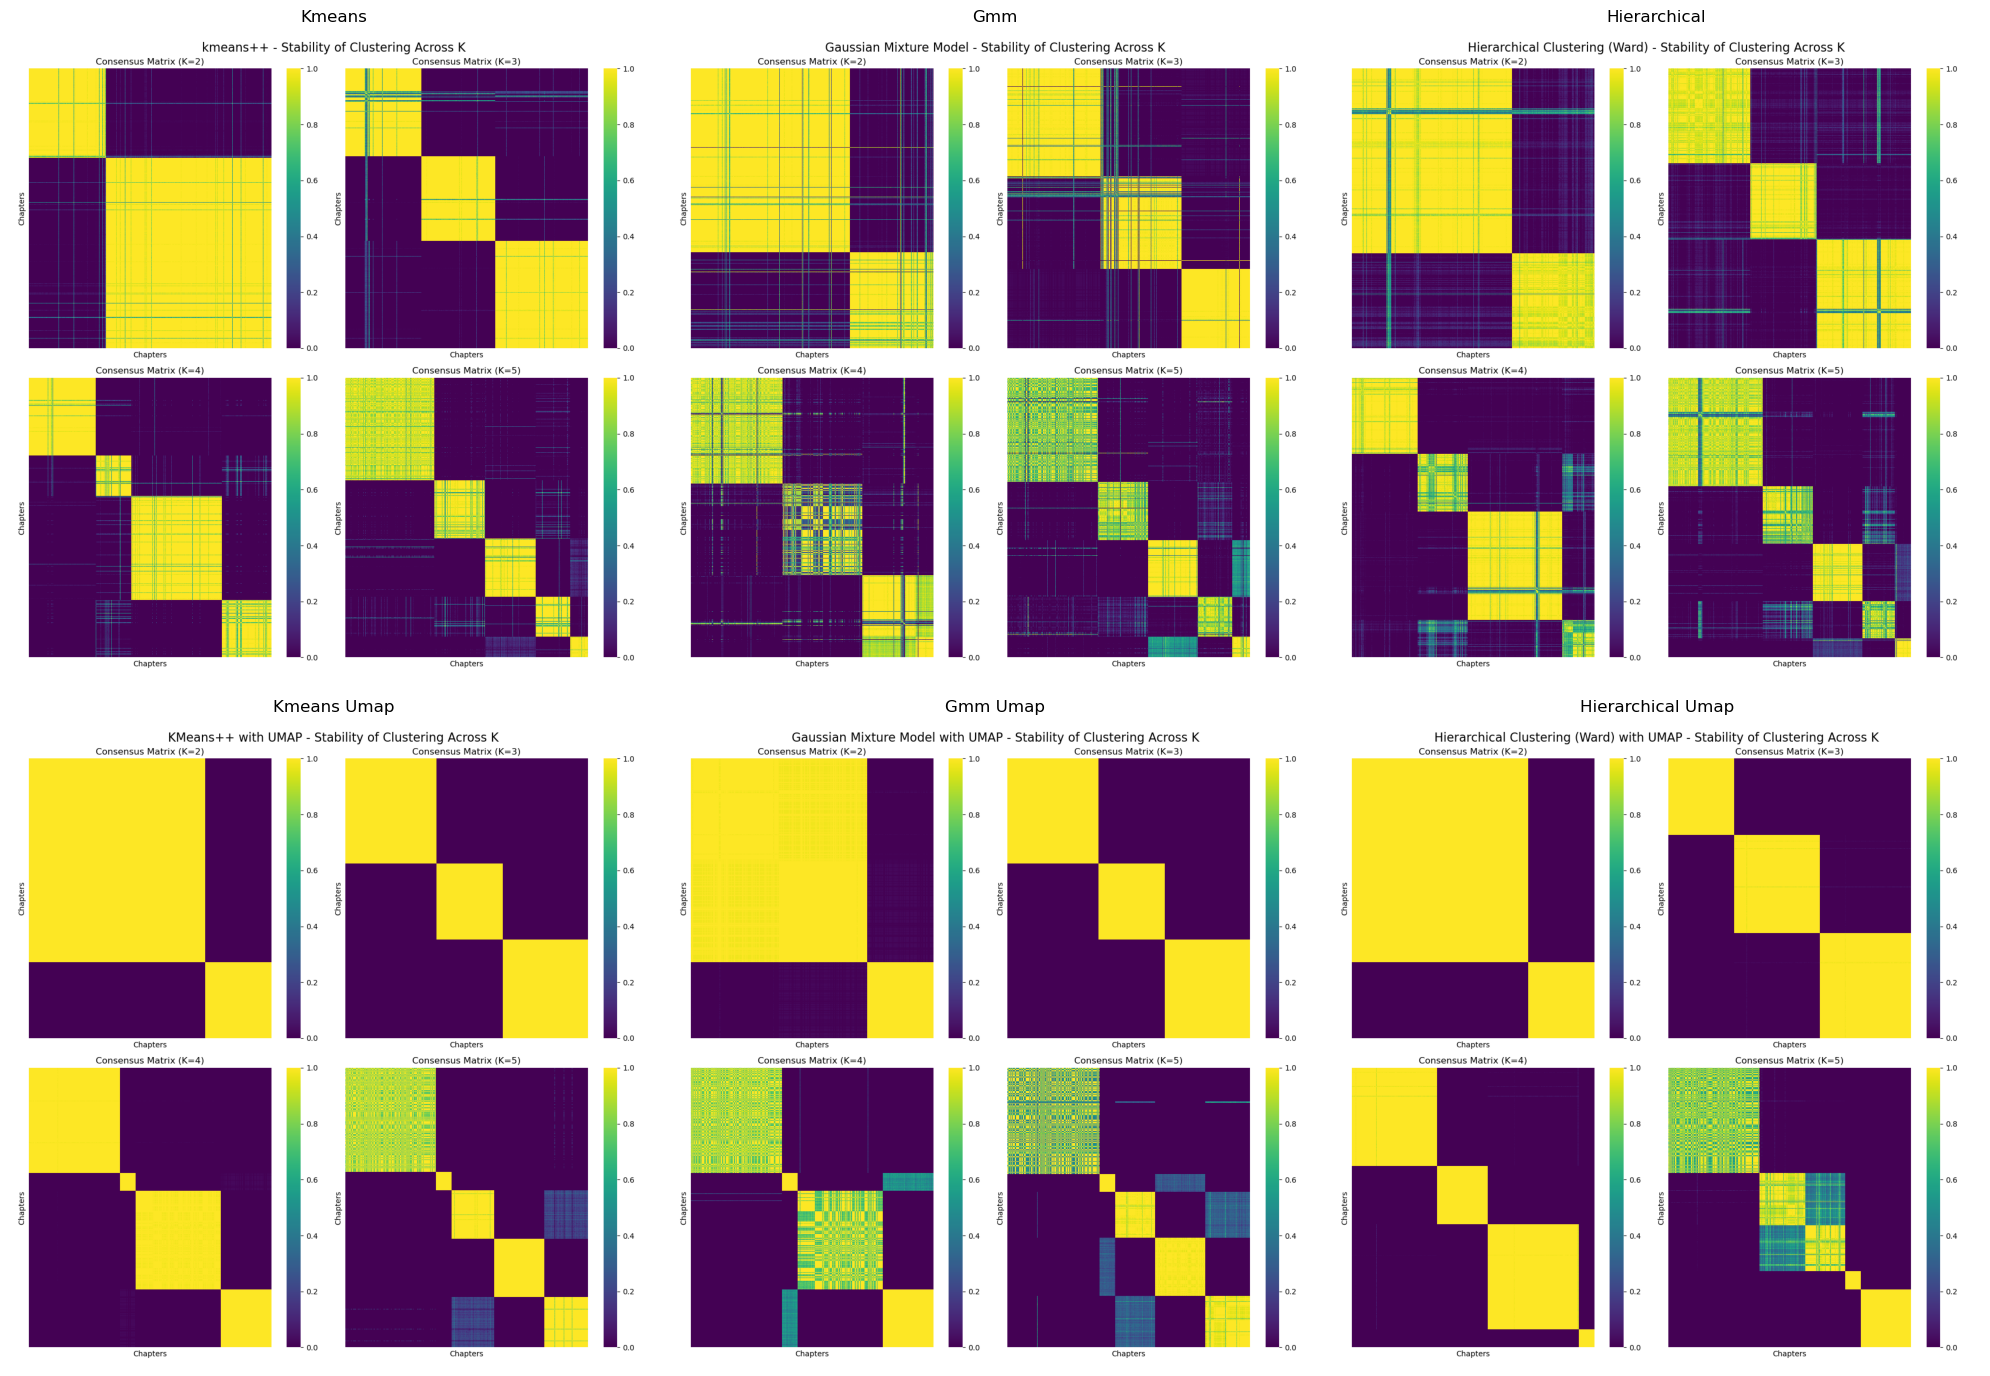

In [43]:
heatmap_paths = [
    "Media/05_consensus_heatmaps_kmeans.png",
    "Media/05_consensus_heatmaps_gmm.png",
    "Media/05_consensus_heatmaps_hierarchical.png",
    "Media/05_consensus_heatmaps_kmeans_umap.png",
    "Media/05_consensus_heatmaps_gmm_umap.png",
    "Media/05_consensus_heatmaps_hierarchical_umap.png"
]

heatmap_images = [Image.open(path) for path in heatmap_paths]

fig, axes = plt.subplots(2, 3, figsize=(20, 24))
axes = axes.flatten()
for ax, img, path in zip(axes, heatmap_images, heatmap_paths):
    ax.imshow(img)
    ax.set_title(
        os.path.basename(path)
          .replace("05_consensus_heatmaps_", "")
          .replace(".png", "")
          .replace("_", " ")
          .title(),
        fontsize=12
    )
    ax.axis('off')
plt.tight_layout()
fig.subplots_adjust(top=0.68)  # reduce the padding at the top
plt.savefig("Media/05_all_consensus_heatmaps_grid.png")
plt.show()
